<a href="https://colab.research.google.com/github/abdelkadergelany/Intrusion-Detection-in-IoT-Based-Network/blob/main/Final_result/Protocol_AnalyZer_Completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing  Libraries

In [1]:
# data cleaning and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# sklearn: data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder ,MinMaxScaler
from sklearn import preprocessing,svm,metrics

# sklearn: train model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

#Feature selection
from sklearn.feature_selection import chi2,RFE
from sklearn.feature_selection import SelectKBest
import xgboost, lightgbm
from sklearn.svm import SVR

# Data Processing

## Load Data

**UNSW-NB15: a comprehensive data set for network intrusion detection systems**


attack_cat: This dataset has nine types of attacks, namely, Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms.

Label: 0 for normal and 1 for attack records

In [2]:
# Load data
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [3]:
# Look at the first 5 rows
combined_data.head(n=5)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [4]:
# information of the data: 
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 82331
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  din

In [5]:
# check if there are Null values
combined_data.isnull().sum()

dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
label      

In [6]:
# Discard the rows with missing values

data_to_use = combined_data.dropna()

# Shape of the data: we could see that the number of rows remains the same as no null values were reported
data_to_use.shape

(257673, 44)

<h1>Contamination mean pollution (outliers) in data</h1>

In [7]:
# Contaminsation mean pollution (outliers) in data
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(1 - len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test  contamination ", round(1 - len(tmp)/len(test),2),'\n')

if contamination > 0.5:
    print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
    contamination = round(1-contamination,2)
    print(f'contamination is now {contamination}')

train contamination  0.68
test  contamination  0.55 

contamination is 0.68, which is greater than 0.5. Fixing...
contamination is now 0.32


#Visualizing The Contamination





In [8]:
#Visualize Class ratio

def class_ratio(title,data):
    val_class = data['label'].values

    print('The class ratio for the  dataset:', data_ratio(val_class))
    sns.countplot(val_class,label="Sum").set_title(title + 'contamination ratio')

In [9]:
# Calculate Y2 ratio
def data_ratio(y2):
    '''
    Calculate Y2's ratio
    '''
    unique, count = np.unique(y2, return_counts=True)
    ratio = round(count[0]/count[1], 1)
    return f'{ratio}:1 ({count[0]}/{count[1]})'

In [10]:
combined_data = pd.concat([train, test]).drop(['id'],axis=1)
attacks_type = combined_data['attack_cat'].values
class_type = combined_data['label'].values

In [11]:
combined_data['label'].values

array([0, 0, 0, ..., 0, 0, 0])

The class ratio for the original data: 1.1:1 (2677/2329)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


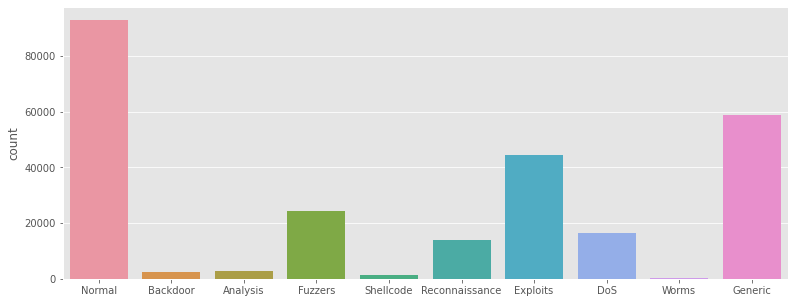

The class ratio for the original data: 0.6:1 (93000/164673)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


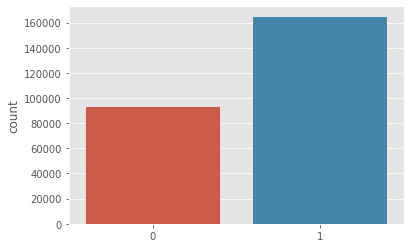

In [12]:
print('The class ratio for the original data:', data_ratio(attacks_type))
plt.figure(figsize=(13,5))
sns.countplot(attacks_type,label="Sum")
plt.show()

print('The class ratio for the original data:', data_ratio(class_type))
sns.countplot(class_type,label="Sum")
plt.show()

In [ ]:
combined_data.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.2956,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.0,0.0,0.0,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.9150,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.0,0.0,0.0,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0


#Protocol Analyzer

In [13]:
#Explore different protocols
import collections
from tabulate import tabulate
counter = collections.Counter(combined_data['proto'])  
print(tabulate(counter.most_common(),headers = ['Type','Occurences']))

Type           Occurences
-----------  ------------
tcp                123041
udp                 92701
unas                15599
arp                  3846
ospf                 3271
sctp                 1474
any                   396
gre                   313
rsvp                  264
ipv6                  262
sun-nd                255
swipe                 253
mobile                253
pim                   253
sep                   251
prm                   133
xns-idp               133
leaf-1                133
ddp                   132
ipv6-frag             132
cftp                  132
wsn                   132
pvp                   132
wb-expak              132
mtp                   132
pri-enc               132
sat-mon               132
cphb                  132
iso-ip                132
xtp                   132
il                    132
mfe-nsp               132
3pc                   132
ipv6-route            132
idrp                  132
bna                   132
kryptolan   

In [14]:
#Separate data according to protocol
udp_data = combined_data.where(combined_data['proto'] == "udp").dropna()
tcp_data = combined_data.where(combined_data['proto'] == "tcp").dropna()
other_prot_data =  combined_data.where(combined_data['proto'] != "tcp").dropna()
other_prot_data =  other_prot_data.where(other_prot_data['proto'] != "udp").dropna()


In [15]:
udp_data.shape

(92701, 44)

In [16]:
tcp_data.shape

(123041, 44)

In [17]:
other_prot_data.shape

(41931, 44)

The class ratio for the  dataset: 0.3:1 (22019/70682)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


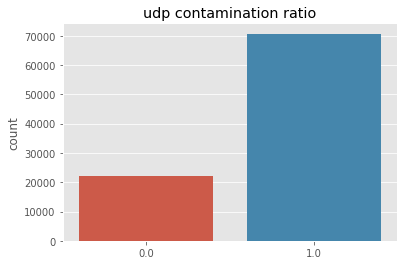

In [18]:
class_ratio('udp ',udp_data)


The class ratio for the  dataset: 1.2:1 (66969/56072)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


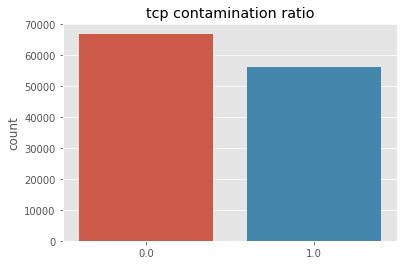

In [ ]:
class_ratio('tcp ',tcp_data)

The class ratio for the  dataset: 0.1:1 (4012/37919)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


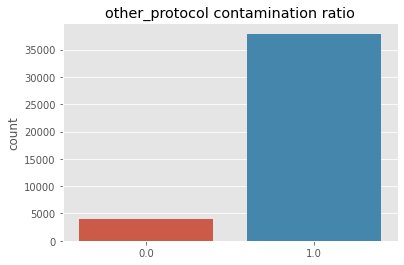

In [ ]:
class_ratio('other_protocol ',other_prot_data)

In [19]:
#Under sampling
!pip install imbalanced-learn


In [20]:
import imblearn
print(imblearn.__version__)

0.4.3


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [21]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

<h1>define undersampling strategy</h1>

In [22]:
# define undersampling strategy
def undersampling(strategy,X_train, y_train):
    undersample = RandomUnderSampler(sampling_strategy=strategy)
    # fit and apply the transform
    X_over, y_over = undersample.fit_resample(X_train, y_train)
    return  X_over,y_over

<h1>define Oversampling strategy</h1>

In [23]:
# define Oversampling strategy
def oversampling(strategy,X_train, y_train):
    oversample = RandomOverSampler(sampling_strategy=strategy)
    # fit and apply the transform
    X_over, y_over = oversample.fit_resample(X_train, y_train)
    return  X_over,y_over

In [24]:
#tcp_data.shape
print(Counter(udp_data['label']))

Counter({1.0: 70682, 0.0: 22019})


#Encoding non numeric Values

In [25]:
#define function to encode categorical values from data
def encode_data(data):
    le1 = LabelEncoder()
    le = LabelEncoder()
    vector = data['attack_cat']

    print("attack cat:", set(list(vector))) # use print to make it print on single line 

    data['attack_cat'] = le1.fit_transform(vector)
    data['proto'] = le.fit_transform(data['proto'])
    data['service'] = le.fit_transform(data['service'])
    data['state'] = le.fit_transform(data['state'])
    return data


In [26]:
udp_data = encode_data( udp_data)
tcp_data = encode_data( tcp_data)
other_prot_data = encode_data( other_prot_data)

attack cat: {'Fuzzers', 'Exploits', 'Shellcode', 'DoS', 'Worms', 'Generic', 'Normal', 'Backdoor', 'Reconnaissance'}
attack cat: {'Fuzzers', 'Exploits', 'Shellcode', 'DoS', 'Worms', 'Analysis', 'Generic', 'Normal', 'Backdoor', 'Reconnaissance'}
attack cat: {'Fuzzers', 'Exploits', 'DoS', 'Analysis', 'Generic', 'Normal', 'Backdoor', 'Reconnaissance'}


In [27]:
udp_data.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
15,0.000002,0,4,1,2.0,0.0,138.0,0.0,500000.00130,254.0,0.0,276000000.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,2.0,1.0,0.0,5,0.0
29,0.000012,0,0,1,2.0,0.0,1414.0,0.0,83333.33039,254.0,0.0,471333312.0,0.0,0.0,0.0,0.012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,707.0,0.0,0.0,0.0,7.0,2.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,2.0,3.0,0.0,5,0.0


#Normalizing Dataset

In [28]:
def normalize_data(data):
    scaler = preprocessing.MinMaxScaler()
    names = data.columns
    d = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(d, columns=names)
    return scaled_df

In [29]:
udp_data = normalize_data( udp_data)
tcp_data = normalize_data( tcp_data)
other_prot_data = normalize_data( other_prot_data)

<h1>Splitting the dataset</h1>

In [30]:
# droped label
udp_data_x = udp_data.drop(['attack_cat','label'], axis=1) 
udp_data_y = udp_data.loc[:,['label']]

tcp_data_x = tcp_data.drop(['attack_cat','label'], axis=1) 
tcp_data_y = tcp_data.loc[:,['label']]

other_data_x = other_prot_data.drop(['attack_cat','label'], axis=1) 
other_data_y = other_prot_data.loc[:,['label']]

udp_X_train, udp_X_test, udp_y_train, udp_y_test = train_test_split(udp_data_x, udp_data_y, test_size=.20, random_state=42) 
tcp_X_train, tcp_X_test, tcp_y_train, tcp_y_test = train_test_split(tcp_data_x, tcp_data_y, test_size=.20, random_state=42) 
other_X_train, other_X_test, other_y_train, other_y_test = train_test_split(other_data_x, other_data_y, test_size=.20, random_state=42) 

#Features selection

In [97]:
#Feature selection with chi2
def feat_select_chi2(data_x,data_y):
  chi2_selector = SelectKBest(chi2, k=25)
  X_train_kbest = chi2_selector.fit_transform(data_x, data_y)
  X_train_kbest
  return X_train_kbest

In [33]:
#Feature selection with RFE
def feat_select_RFE(data_x,data_y):
  estimator = DecisionTreeClassifier()
  selector = RFE(estimator, n_features_to_select=25, step=1)
  data_transform = selector.fit_transform(data_x, data_y) 
  return data_transform

#Feature ranking

In [ ]:
colnames = udp_X_train.columns
colnames

In [86]:
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [104]:
def  print_ranking(rlist):
    meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Ranking'])

    # Sort the dataframe
    meanplot = meanplot.sort_values('Ranking', ascending=False)
    # Let's plot the ranking of the features
    sns.factorplot(x="Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')

In [103]:
def get_feature_ranking_Chi2():
    selector = SelectKBest(chi2, k=25)
    selector.fit(udp_X_train, udp_y_train)
    ranks['CHi2'] = ranking(list(map(float, selector.scores_)), colnames, order=-1)
    # Create empty dictionary to store the mean value calculated from all the scores
    r = {}
    for name in colnames:
        r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")
 
    print("\t%s" % "\t".join(methods))
    for name in colnames:
        print("%s\t%s" % (name, "\t".join(map(str, 
                             [ranks[method][name] for method in methods]))))
    print_ranking(r)

In [105]:
def get_feature_ranking_RFE():
    estimator = DecisionTreeClassifier()
    selector = RFE(estimator, n_features_to_select=25, step=1, verbose =3)
    selector.fit(udp_X_train, udp_y_train) 
    ranks['RFE'] = ranking(list(map(float, selector.ranking_)), colnames, order=-1)
    # Create empty dictionary to store the mean value calculated from all the scores
    r = {}
    for name in colnames:
        r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")
 
    print("\t%s" % "\t".join(methods))
    for name in colnames:
        print("%s\t%s" % (name, "\t".join(map(str, 
                             [ranks[method][name] for method in methods]))))
    print_ranking(r)

	CHi2	Mean	RFE	Mean
dur	1.0	1.0	1.0	1.0
proto	nan	nan	nan	nan
service	0.94	0.95	0.94	0.95
state	0.77	0.81	0.77	0.81
spkts	1.0	0.98	1.0	0.98
dpkts	1.0	0.99	1.0	0.99
sbytes	1.0	1.0	1.0	1.0
dbytes	1.0	1.0	1.0	1.0
rate	0.9	0.92	0.9	0.92
sttl	0.54	0.62	0.54	0.62
dttl	0.79	0.73	0.79	0.73
sload	1.0	1.0	1.0	1.0
dload	0.0	0.17	0.0	0.17
sloss	nan	nan	nan	nan
dloss	nan	nan	nan	nan
sinpkt	1.0	1.0	1.0	1.0
dinpkt	1.0	0.93	1.0	0.93
sjit	1.0	1.0	1.0	1.0
djit	1.0	0.87	1.0	0.87
swin	nan	nan	nan	nan
stcpb	nan	nan	nan	nan
dtcpb	nan	nan	nan	nan
dwin	nan	nan	nan	nan
tcprtt	nan	nan	nan	nan
synack	nan	nan	nan	nan
ackdat	nan	nan	nan	nan
smean	0.98	0.98	0.98	0.98
dmean	0.8	0.75	0.8	0.75
trans_depth	nan	nan	nan	nan
response_body_len	nan	nan	nan	nan
ct_srv_src	0.85	0.87	0.85	0.87
ct_state_ttl	0.84	0.86	0.84	0.86
ct_dst_ltm	0.86	0.88	0.86	0.88
ct_src_dport_ltm	0.82	0.85	0.82	0.85
ct_dst_sport_ltm	0.79	0.83	0.79	0.83
ct_dst_src_ltm	0.82	0.85	0.82	0.85
is_ftp_login	nan	nan	nan	nan
ct_ftp_cmd	nan	nan	nan	nan
ct_flw_h

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


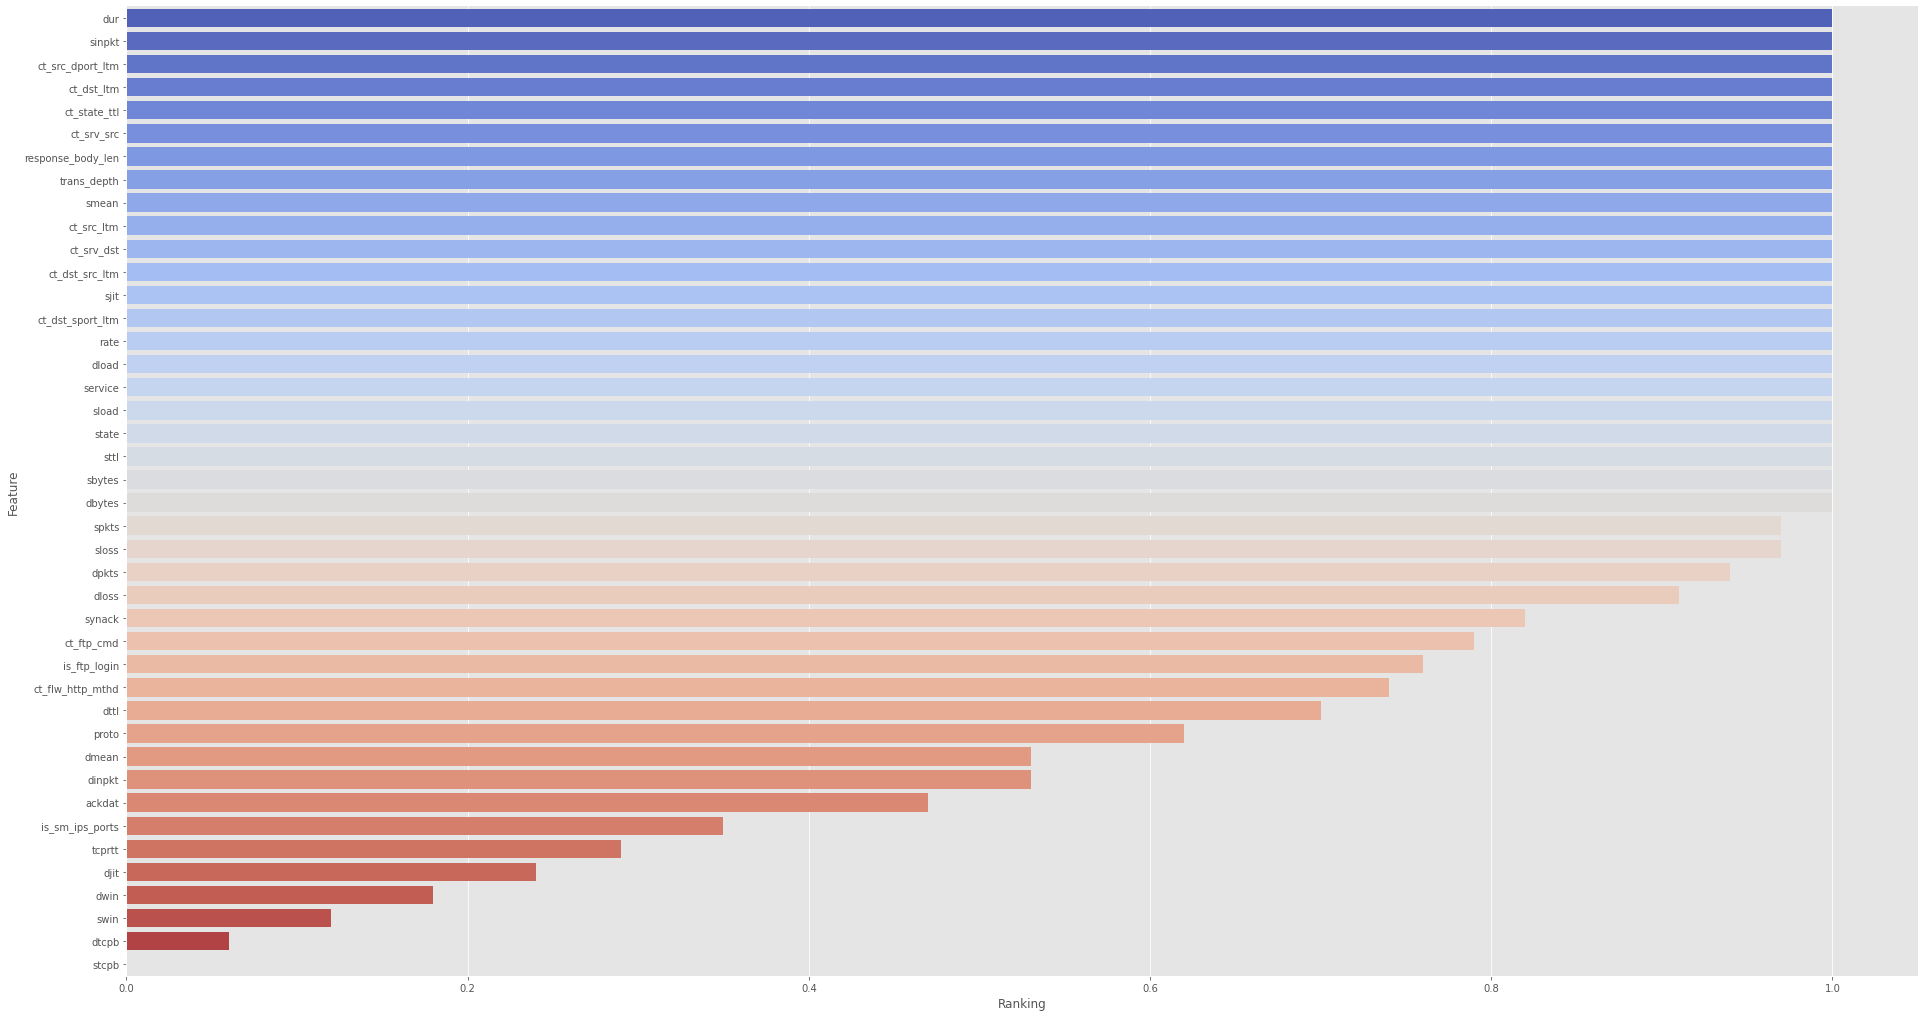

In [106]:
get_feature_ranking_Chi2()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
	CHi2	Mean	RFE	Mean
dur	1.0	1.0	1.0	1.0
proto	nan	nan	0.71	nan
service	0.94	0.96	1.0	0.96
state	0.77	0.86	1.0	0.86
spkts	1.0	0.99	1.0	0.99
dpkts	1.0	0.96	0.88	0.96
sbytes	1.0	1.0	1.0	1.0
dbytes	1.0	1.0	1.0	1.0
rate	0.9	0.94	1.0	0.94
sttl	0.54	0.72	1.0	0.72
dttl	0.79	0.64	0.41	0.64
sload	1.0	1.0	1.0	1.0
dload	0.0	0.39	1.0	0.39
sloss	nan	nan	1.0	nan
dloss	nan	nan	1.0	nan
sinpkt	1.0	1.0	1

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


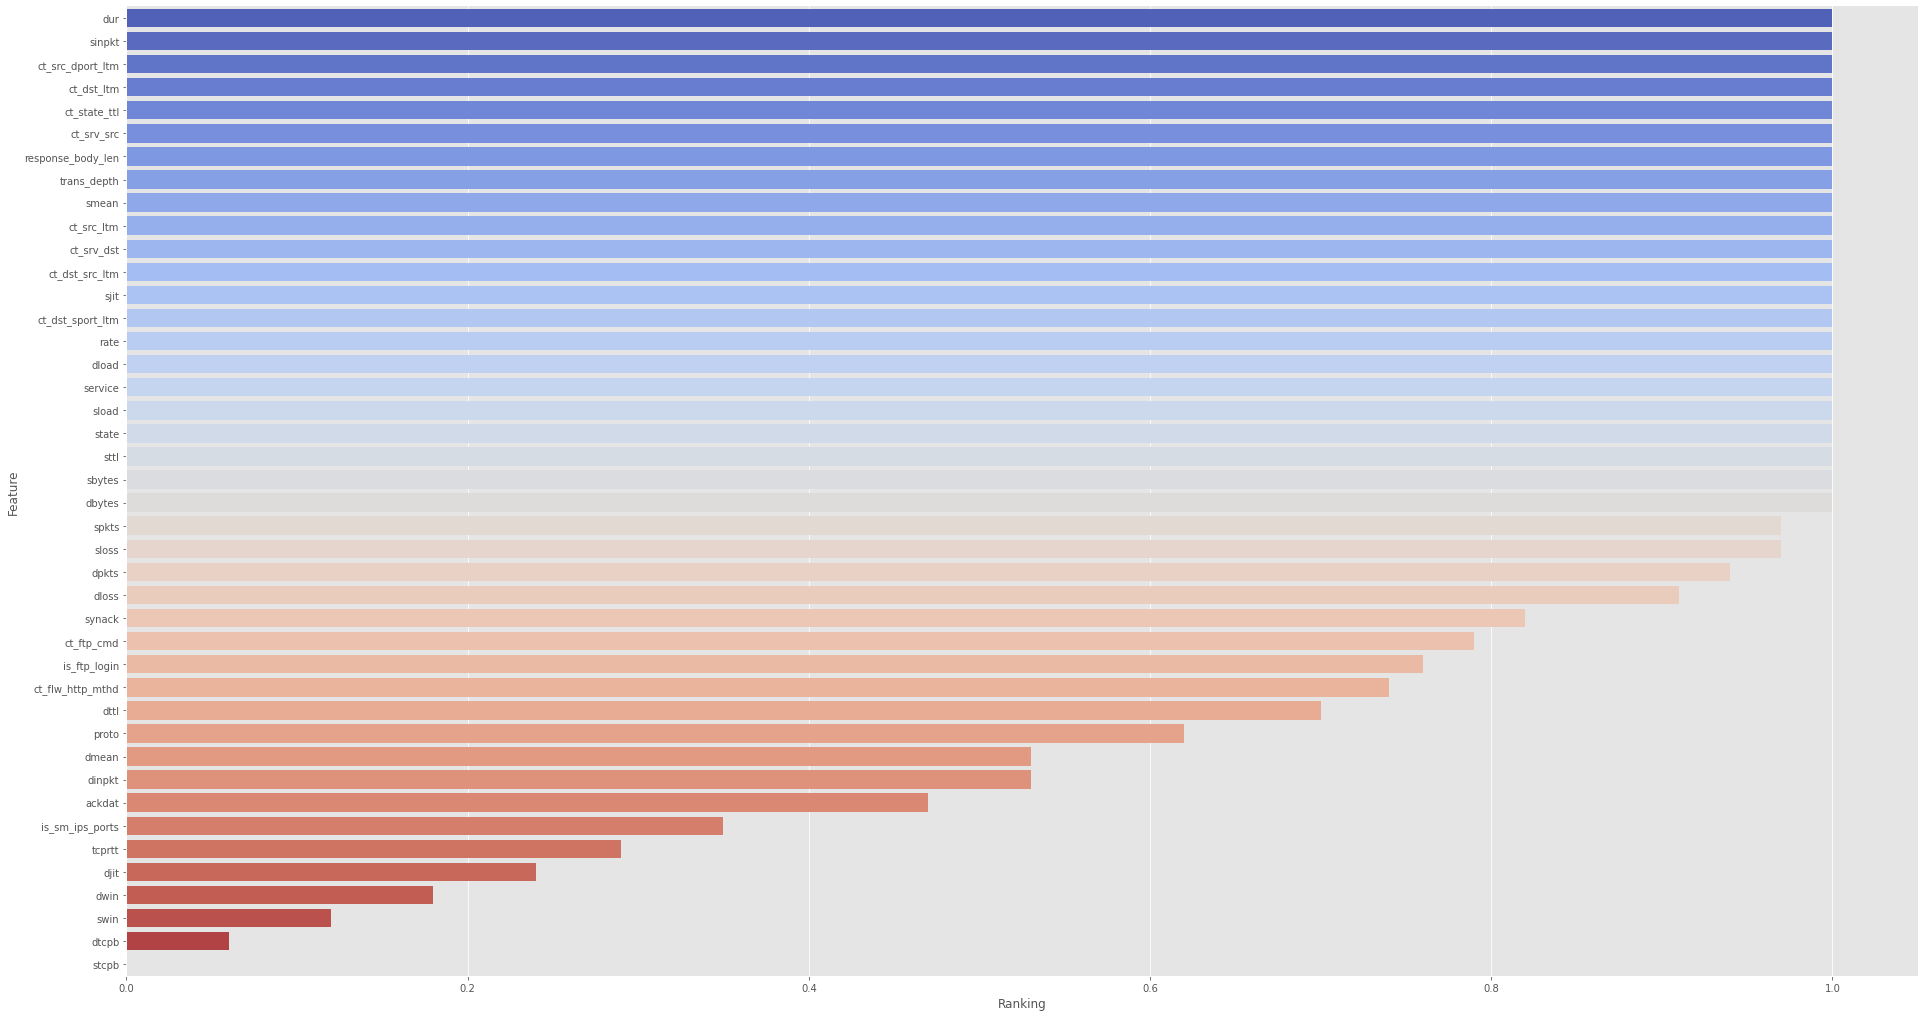

In [107]:
get_feature_ranking_RFE()

<h1>Estimate score </h1>

In [34]:
# ===== Step 1: cross-validation ========

def estimate_score(clf,x_train,y_train):
    #clf = svm.SVC(kernel='linear') # Linear Kernel

    # define  Stratified 5-fold cross-validator, it provides train/validate indices to split data in train/validate sets.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    # define metrics for evaluating
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    #perform the 5-fold CV and get the metrics results
    cv_results = cross_validate(estimator=clf,
                            X = x_train,
                            y = y_train, 
                            scoring = scoring,
                            cv = cv,
                            return_train_score = False)
    return cv_results

In [35]:
# ======== Step 2: Evaluate the model using testing data =======

def evaluate_model(type,clf,x_train_d,x_test_d,y_train_d,y_test_d):
    
    # fit the Logistic Regression model
    if type == 'knn':
        clf.fit(X=x_train_d)
    else:
        clf.fit(X=x_train_d, y=y_train_d)

    # predition on testing data
    y_pred_class = clf.predict(X=x_test_d)
    #y_pred_score = clf.predict_proba(X=x_test_d)[:, 1]

    # AUC of ROC
    #auc_ontest = roc_auc_score(y_true=y_test_d, y_score=y_pred_score)
    # confusion matrix
    cm_ontest = confusion_matrix(y_true=y_test_d, y_pred=y_pred_class)
    # precision score
    precision_ontest = precision_score(y_true=y_test_d, y_pred=y_pred_class)
    # recall score
    recall_ontest = recall_score(y_true=y_test_d, y_pred=y_pred_class)
    # classifition report
    cls_report_ontest = classification_report(y_true=y_test_d, y_pred=y_pred_class)

    # print the above results
    #print('The model scores {:1.5f} ROC AUC on the test set.'.format(auc_ontest))
    print('The precision score on the test set: {:1.5f}'.format(precision_ontest))
    print('The recall score on the test set: {:1.5f}'.format(recall_ontest))
    print('Confusion Matrix:\n', cm_ontest)
    # Print classification report:
    print('Classification Report:\n', cls_report_ontest)

<h1>Print CV _Results</h1>

In [36]:
def print_cv_results(cv_results):
    for key, value in cv_results.items(): 
      print( key,value.mean())

#UDP Modul

<h1>Estimation of SVM on Chi2 </h1>

In [37]:
clf_svm = svm.SVC(kernel='linear')
estimation = estimate_score(clf_svm,feat_select_chi2(udp_X_train,udp_y_train),udp_y_train['label'].values)
print_cv_results(estimation)

AttributeError: ignored

<h1>Estimation of SVM on RFE </h1>

In [ ]:
estimation = estimate_score(clf_svm,feat_select_RFE(udp_X_train,udp_y_train),udp_y_train['label'].values)
print_cv_results(estimation)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fit_time 26.558034086227416
score_time 5.819858884811401
test_accuracy 0.9421790722761598
test_precision 0.9375389753233927
test_recall 0.9900502913105113
test_f1 0.9630778138166265
test_roc_auc 0.9880111033486203


<h1>Evaluation of Chi2-SVM on Test data</h1>

In [ ]:
evaluate_model('null',clf_svm,feat_select_chi2(udp_X_train,udp_y_train),feat_select_chi2(udp_X_test,udp_y_test),udp_y_train['label'].values,udp_y_test['label'].values)

The precision score on the test set: 0.93897
The recall score on the test set: 0.98944
Confusion Matrix:
 [[ 3430   913]
 [  150 14048]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.79      0.87      4343
         1.0       0.94      0.99      0.96     14198

    accuracy                           0.94     18541
   macro avg       0.95      0.89      0.91     18541
weighted avg       0.94      0.94      0.94     18541



<h1>Evaluation of RFE-SVM on Test data</h1>

In [ ]:
evaluate_model('null',clf_svm,feat_select_RFE(udp_X_train,udp_y_train),feat_select_RFE(udp_X_test,udp_y_test),udp_y_train['label'].values,udp_y_test['label'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The precision score on the test set: 0.01447
The recall score on the test set: 0.00218
Confusion Matrix:
 [[ 2232  2111]
 [14167    31]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.14      0.51      0.22      4343
         1.0       0.01      0.00      0.00     14198

    accuracy                           0.12     18541
   macro avg       0.08      0.26      0.11     18541
weighted avg       0.04      0.12      0.05     18541



<h1> Evaluation of KNN on Chi2 </h1>



In [ ]:
%%capture 
!pip install pyod

In [ ]:
from pyod.models import lof, cblof, cof, pca, iforest, knn, mcd, ocsvm, sod, abod, hbos #, auto_encoder, vae
contamination = 0.4
threshold = 0.75

The class ratio for the  dataset: 0.3:1 (17676/56484)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


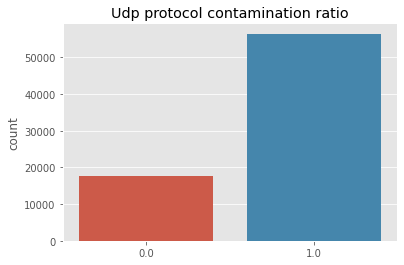

In [ ]:

class_ratio('Udp protocol ',udp_y_train)

In [ ]:
#Resample udp dataset for KNN
# x_resampled, y_resampled = oversampling('minority',udp_X_train,udp_y_train)
tmp_normal = udp_data.where(udp_data['label'] == 0).dropna()
tmp_attack = udp_data.where(udp_data['label'] == 1).dropna()
#tmp_normal = pd.concat([tmp_normal, tmp_attack.sample(n=50000)])
tmp_normal = pd.concat([tmp_normal, tmp_normal])
tmp_normal = pd.concat([tmp_normal, tmp_normal])
tmp_normal = pd.concat([tmp_normal, tmp_attack.sample(n=5000)])
udp_data_x = tmp_normal.drop(['label'], axis=1) 
udp_data_y = tmp_normal.loc[:,['label']]
udp_X_train, udp_X_test, udp_y_train, udp_y_test = train_test_split(udp_data_x, udp_data_y, test_size=.20, random_state=42) 


The class ratio for the  dataset: 17.6:1 (70451/4009)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


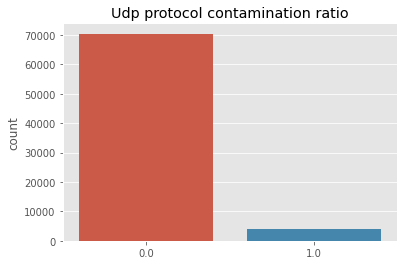

In [ ]:
#Verify resampling
class_ratio('Udp protocol ',udp_y_train)

In [ ]:
#Evaluate Chi2-knn
Xdd = feat_select_chi2(udp_X_train,udp_y_train)
knn_clf = knn.KNN(contamination=contamination, radius=1.5, n_neighbors=20, n_jobs=-1) #TODO radius
_ = knn_clf.fit(Xdd)
evaluate_model('knn',knn_clf,feat_select_chi2(udp_X_train,udp_y_train),feat_select_chi2(udp_X_test,udp_y_test),udp_y_train['label'].values,udp_y_test['label'].values)


The precision score on the test set: 0.05323
The recall score on the test set: 1.00000
Confusion Matrix:
 [[    0 17625]
 [    0   991]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     17625
         1.0       0.05      1.00      0.10       991

    accuracy                           0.05     18616
   macro avg       0.03      0.50      0.05     18616
weighted avg       0.00      0.05      0.01     18616



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h1> Evaluation of KNN on RFE </h1>


In [ ]:
#Evaluate RFE-knn
Xdd = feat_select_RFE(udp_X_train,udp_y_train)
knn_clf = knn.KNN(contamination=contamination, radius=1.5, n_neighbors=20, n_jobs=-1) #TODO radius
_ = knn_clf.fit(Xdd)
evaluate_model('knn',knn_clf,feat_select_RFE(udp_X_train,udp_y_train),feat_select_RFE(udp_X_test,udp_y_test),udp_y_train['label'].values,udp_y_test['label'].values)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The precision score on the test set: 0.10695
The recall score on the test set: 0.80424
Confusion Matrix:
 [[10970  6655]
 [  194   797]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.62      0.76     17625
         1.0       0.11      0.80      0.19       991

    accuracy                           0.63     18616
   macro avg       0.54      0.71      0.48     18616
weighted avg       0.94      0.63      0.73     18616



# TCP Module

<h1> DT-Chi2  </h1>

<h1>Estimate DT-Chi2</h1>




In [ ]:
clf_DT = DecisionTreeClassifier(random_state=123)

estimation = estimate_score(clf_DT,feat_select_chi2(tcp_X_train,tcp_y_train),tcp_y_train['label'].values)
print_cv_results(estimation)

fit_time 1.294320249557495
score_time 0.05309991836547852
test_accuracy 0.8976958613930485
test_precision 0.8878559797737398
test_recall 0.8878792907281058
test_f1 0.8878628758079113
test_roc_auc 0.8969040590730903


<h1>Evaluate DT-Chi2</h1>


In [ ]:
evaluate_model('null',clf_DT,feat_select_chi2(tcp_X_train,tcp_y_train),feat_select_chi2(tcp_X_test,tcp_y_test),tcp_y_train['label'].values,tcp_y_test['label'].values)

The precision score on the test set: 0.86951
The recall score on the test set: 0.86352
Confusion Matrix:
 [[11987  1448]
 [ 1525  9649]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     13435
         1.0       0.87      0.86      0.87     11174

    accuracy                           0.88     24609
   macro avg       0.88      0.88      0.88     24609
weighted avg       0.88      0.88      0.88     24609



<h1>Estimate DT-RFE</h1>


In [ ]:
estimation = estimate_score(clf_DT,feat_select_RFE(tcp_X_train,tcp_y_train),tcp_y_train['label'].values)
print_cv_results(estimation)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fit_time 2.047493839263916
score_time 0.05424456596374512
test_accuracy 0.8972895426345193
test_precision 0.8851626901530889
test_recall 0.8903515354188232
test_f1 0.8877441494675271
test_roc_auc 0.8967298925758438


<h1>Evaluate DT-RFE</h1>


In [ ]:
evaluate_model('null',clf_DT,feat_select_chi2(tcp_X_train,tcp_y_train),feat_select_RFE(tcp_X_test,tcp_y_test),tcp_y_train['label'].values,tcp_y_test['label'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The precision score on the test set: 0.44972
The recall score on the test set: 0.79246
Confusion Matrix:
 [[ 2600 10835]
 [ 2319  8855]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.19      0.28     13435
         1.0       0.45      0.79      0.57     11174

    accuracy                           0.47     24609
   macro avg       0.49      0.49      0.43     24609
weighted avg       0.49      0.47      0.42     24609



<h1>Estimate LR-Chi2</h1>


In [ ]:

clf_LR = LogisticRegression(solver='lbfgs', random_state=123, max_iter = 4000)

estimation = estimate_score(clf_LR,feat_select_chi2(tcp_X_train,tcp_y_train),tcp_y_train['label'].values)
print_cv_results(estimation)

fit_time 3.6884058475494386
score_time 0.07105422019958496
test_accuracy 0.8427747246541877
test_precision 0.7755185042858262
test_recall 0.9223794520795987
test_f1 0.8425694439210523
test_roc_auc 0.939371381311464


<h1>Evaluate LR-Chi2</h1>


In [ ]:
evaluate_model('null',clf_LR,feat_select_chi2(tcp_X_train,tcp_y_train),feat_select_RFE(tcp_X_test,tcp_y_test),tcp_y_train['label'].values,tcp_y_test['label'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The precision score on the test set: 0.70556
The recall score on the test set: 0.97790
Confusion Matrix:
 [[ 8875  4560]
 [  247 10927]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.66      0.79     13435
         1.0       0.71      0.98      0.82     11174

    accuracy                           0.80     24609
   macro avg       0.84      0.82      0.80     24609
weighted avg       0.85      0.80      0.80     24609



<h1>Estimate LR-RFE</h1>


In [ ]:
estimation = estimate_score(clf_LR,feat_select_RFE(tcp_X_train,tcp_y_train),tcp_y_train['label'].values)
print_cv_results(estimation)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fit_time 2.5904373645782472
score_time 0.06803226470947266
test_accuracy 0.8374918887683581
test_precision 0.7708606139469347
test_recall 0.9160985258600183
test_f1 0.8372065143427075
test_roc_auc 0.936126320262197


<h1>Evaluate LR-RFE</h1>


In [ ]:
evaluate_model('null',clf_LR,feat_select_RFE(tcp_X_train,tcp_y_train),feat_select_RFE(tcp_X_test,tcp_y_test),tcp_y_train['label'].values,tcp_y_test['label'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The precision score on the test set: 0.00000
The recall score on the test set: 0.00000
Confusion Matrix:
 [[13433     2]
 [11174     0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      1.00      0.71     13435
         1.0       0.00      0.00      0.00     11174

    accuracy                           0.55     24609
   macro avg       0.27      0.50      0.35     24609
weighted avg       0.30      0.55      0.39     24609



# Other Protocols  Modul

<h1>EStimate MLP-Chi2</h1>

In [ ]:
clf_MLP = MLPClassifier(random_state=123, solver='adam', max_iter=8000)

estimation = estimate_score(clf_MLP,feat_select_chi2(other_X_train,other_y_train),other_y_train['label'].values)
print_cv_results(estimation)

fit_time 6.203765201568603
score_time 0.0385930061340332
test_accuracy 0.998956603208268
test_precision 0.9988486840503524
test_recall 1.0
test_f1 0.9994239861291397
test_roc_auc 0.9997705966321313


<h1>Evaluate MLP-Chi2</h1>

In [ ]:
evaluate_model('null',clf_MLP,feat_select_chi2(other_X_train,other_y_train),feat_select_chi2(other_X_test,other_y_test),other_y_train['label'].values,other_y_test['label'].values)

The precision score on the test set: 0.99868
The recall score on the test set: 1.00000
Confusion Matrix:
 [[ 820   10]
 [   0 7557]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       830
         1.0       1.00      1.00      1.00      7557

    accuracy                           1.00      8387
   macro avg       1.00      0.99      1.00      8387
weighted avg       1.00      1.00      1.00      8387



<h1>EStimate MLP-RFE</h1>

In [ ]:
estimation = estimate_score(clf_MLP,feat_select_RFE(other_X_train,other_y_train),other_y_train['label'].values)
print_cv_results(estimation)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fit_time 5.186378097534179
score_time 0.03635892868041992
test_accuracy 0.9990460397584462
test_precision 0.9989472924879239
test_recall 1.0
test_f1 0.9994733404001493
test_roc_auc 0.9997202755736565


<h1>Evaluate MLP-RFE</h1>

In [ ]:
evaluate_model('null',clf_MLP,feat_select_RFE(other_X_train,other_y_train),feat_select_RFE(other_X_test,other_y_test),other_y_train['label'].values,other_y_test['label'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The precision score on the test set: 0.99984
The recall score on the test set: 0.84743
Confusion Matrix:
 [[ 829    1]
 [1153 6404]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.42      1.00      0.59       830
         1.0       1.00      0.85      0.92      7557

    accuracy                           0.86      8387
   macro avg       0.71      0.92      0.75      8387
weighted avg       0.94      0.86      0.88      8387

